In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.font_manager
import matplotlib as mpl

path = Path.cwd()
root_path = list(path.parents)[1]
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=[path.parent / "figures" / 'fonts'], fontext='ttf')
matplotlib.font_manager.fontManager.addfont(font_files[0])

# specify matplotlib rc file
plt.style.use(root_path / ".matplotlibrc")
mpl.rcParams['font.family'] = 'Arial'

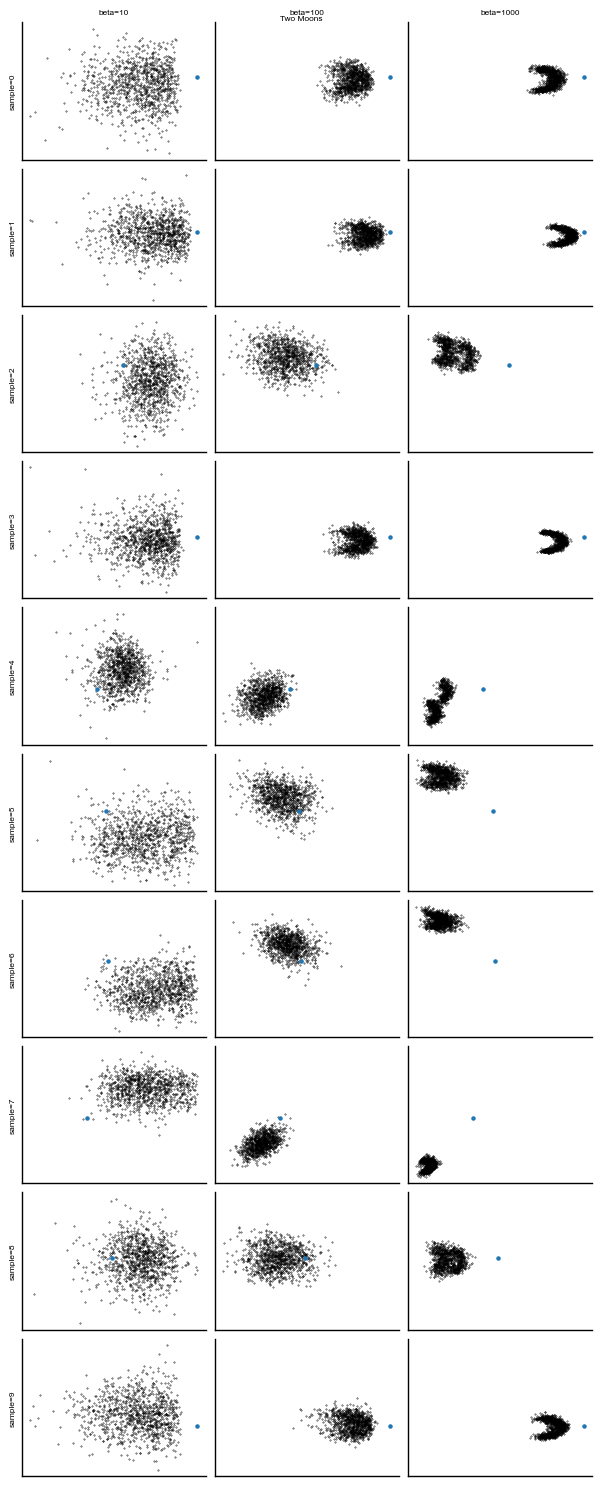

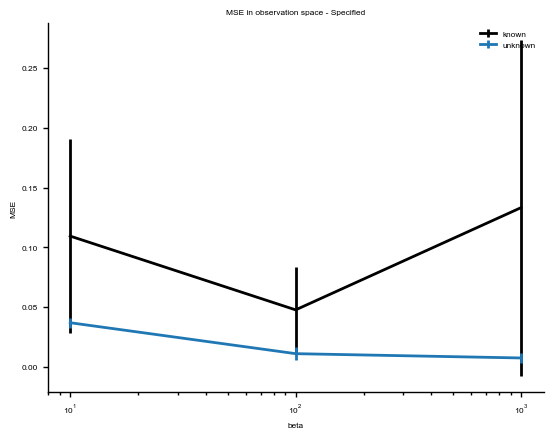

In [14]:
mapl = torch.load(
    "../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/specified_known_evaluate_samples.pt"
)
res_unknown = torch.load(
    "../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/specified_unknown_evaluate_samples.pt"
)

fig, axs = plt.subplots(ncols=3, nrows=10, figsize=(6, 15), sharex="row", sharey="row")

for row, col in np.ndindex(10, 3):
    ax = axs[row, col]
    ax.scatter(*res_known["x_pred"][col, :, row].T.detach().numpy(), s=0.1)
    ax.scatter(*res_known["x_o"][row], s=5)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if row == 0:
        beta = res_known["betas"][col]
        ax.set_title(f"{beta=}")

    if col == 0:
        ax.set_ylabel(f"sample={row}")

fig.suptitle("Two Moons")
fig.tight_layout()

fig, ax = plt.subplots()

diff = torch.mean((res_known["x_pred"] - res_known["x_o"]) ** 2, dim=-1).detach()
mean = diff.mean(dim=1)
# for row in range(10):
#     ax.plot(res_known["betas"], mean, color="k", alpha=0.01)
ax.errorbar(res_known["betas"], mean.mean(dim=1), mean.std(dim=1), linewidth=2, label="known")

diff = torch.mean((res_unknown["x_pred"] - res_unknown["x_o"]) ** 2, dim=-1).detach()
mean = diff.mean(dim=1)
# for row in range(10):
#     ax.plot(res_known["betas"], mean, color="k", alpha=0.01)
ax.errorbar(res_unknown["betas"], mean.mean(dim=1), mean.std(dim=1), linewidth=2, label="unknown")

ax.set_xscale("log")
ax.set_title("MSE in observation space - Specified")
ax.set_xlabel("beta")
ax.set_ylabel("MSE")
ax.legend()

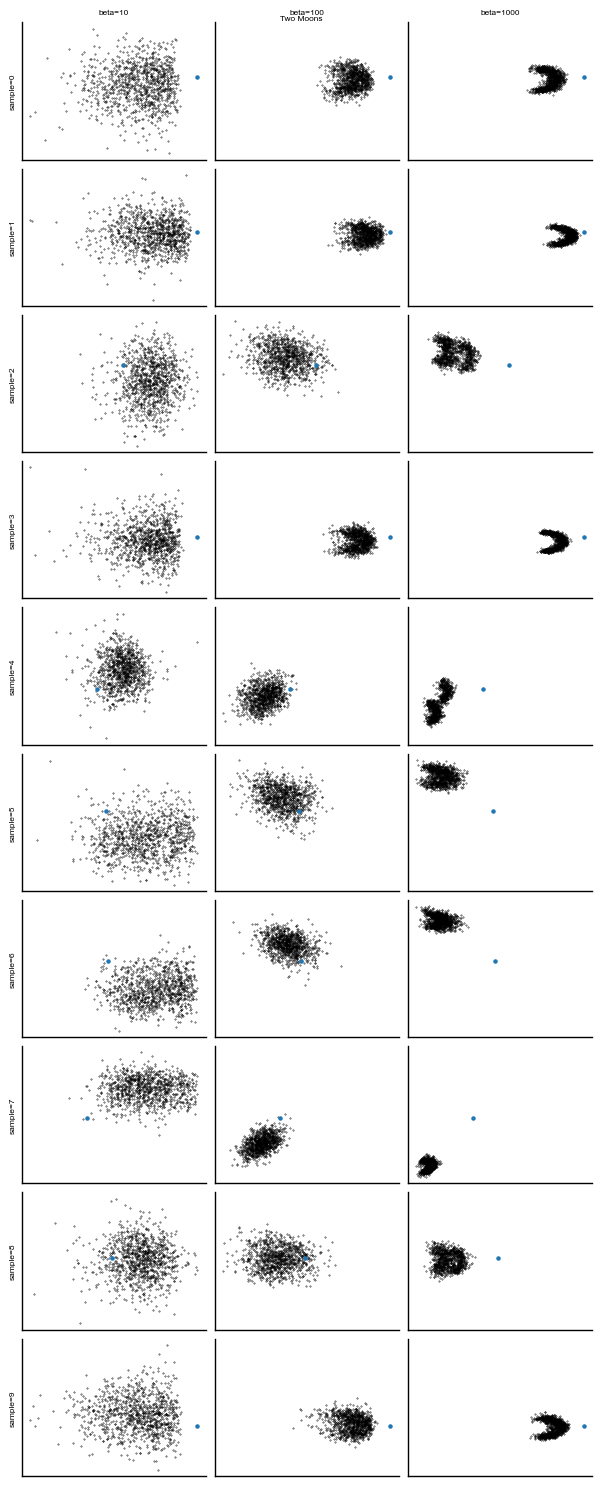

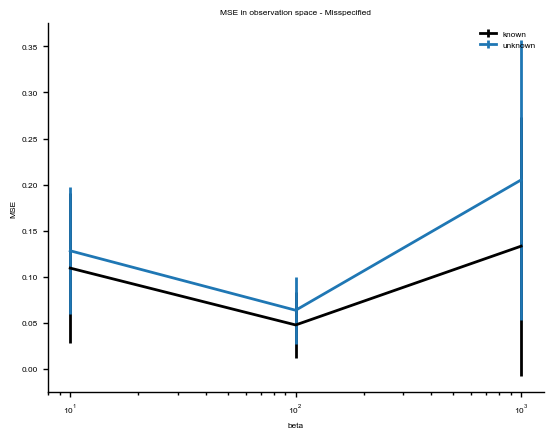

In [15]:
res_known = torch.load("../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_known_evaluate_samples.pt")
res_unknown = torch.load("../../results/diffusion/two_moons/lightning_logs/version_0/samples_epoch=99-step=4000/misspecified_unknown_evaluate_samples.pt")

fig, axs = plt.subplots(ncols=3, nrows=10, figsize=(6, 15), sharex="row", sharey="row")

for row, col in np.ndindex(10, 3):
    ax = axs[row, col]
    ax.scatter(*res_known["x_pred"][col, :, row].T.detach().numpy(), s=0.1)
    ax.scatter(*res_known["x_o"][row], s=5)
    ax.set_xticks([],[])
    ax.set_yticks([],[])
    if row == 0:
        beta = res_known["betas"][col]
        ax.set_title(f"{beta=}")

    if col == 0:
        ax.set_ylabel(f"sample={row}")

fig.suptitle("Two Moons")
fig.tight_layout()

fig, ax = plt.subplots()

diff = torch.mean((res_known["x_pred"] - res_known["x_o"]) ** 2, dim=-1).detach()
mean = diff.mean(dim=1)
# for row in range(10):
#     ax.plot(res_known["betas"], mean, color="k", alpha=0.01)
ax.errorbar(res_known["betas"], mean.mean(dim=1), mean.std(dim=1), linewidth=2, label="known")

diff = torch.mean((res_unknown["x_pred"] - res_unknown["x_o"]) ** 2, dim=-1).detach()
mean = diff.mean(dim=1)
# for row in range(10):
#     ax.plot(res_known["betas"], mean, color="k", alpha=0.01)
ax.errorbar(res_unknown["betas"], mean.mean(dim=1), mean.std(dim=1), linewidth=2, label="unknown")

ax.set_xscale("log")
ax.set_title("MSE in observation space - Misspecified")
ax.set_xlabel("beta")
ax.set_ylabel("MSE")
ax.legend()

In [16]:
from glob import glob
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product


res_base_path = Path("../../results/diffusion")
task = "two_moons"
log_dir = res_base_path / task / "lightning_logs" / "version_0"

dfs = []
for res_path in log_dir.glob("*/*_evaluate_samples.pt"):
    content = torch.load(res_path)
    mse = torch.mean((content["x_pred"] - content["x_o"]) ** 2, dim=-1).detach()
    mse = mse.mean((1))
    specified, known, _, _ = res_path.stem.split("_")

    data = {
        "task": task,
        "specified": specified,
        "known": known,
        "betas": content["betas"],
        "mse_mean": mse.mean(-1),
        "mse_std": mse.std(-1),
    }
    dfs.append(pd.DataFrame(data))
df = pd.concat(dfs)
df

,task,specified,known,betas,mse_mean,mse_std
0,two_moons,misspecified,known,10,0.109386,0.081176
1,two_moons,misspecified,known,100,0.047688,0.035706
2,two_moons,misspecified,known,1000,0.133200,0.140494
0,two_moons,specified,known,10,0.037338,0.003244
1,two_moons,specified,known,100,0.010348,0.003334
2,two_moons,specified,known,1000,0.008263,0.006494
0,two_moons,specified,unknown,10,0.036930,0.004260
1,two_moons,specified,unknown,100,0.011059,0.005572
2,two_moons,specified,unknown,1000,0.007464,0.004527
0,two_moons,misspecified,unknown,10,0.128185,0.069092


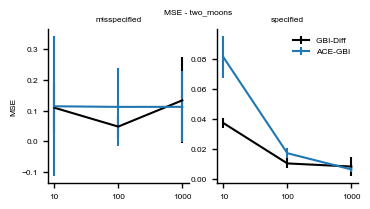

In [ ]:
tasks = df["task"].unique().tolist()
specifieds = df["specified"].unique().tolist()

fig, axs = plt.subplots(nrows=len(tasks), ncols=len(specifieds), figsize=(4, 2))

for idx, data in df.groupby(["task", "specified", "known"]):
    task, specified, known = idx

    if known == "unknown":
        continue
    betas = data["betas"]

    row_idx = tasks.index(task)
    col_idx = specifieds.index(specified)
    ax = axs[col_idx]
    ax.errorbar(
        data["betas"].astype(str), data["mse_mean"], data["mse_std"], label="GBI-Diff "
    )
    ax.set_title(specified)

axs[0].set_ylabel("MSE")

fig.suptitle(f"MSE - {task}")


gbi_benchmark_misspecified = {
    "betas": ["10", "100", "1000"],
    "mean": [0.113898, 0.111917, 0.112072],
    "std": [0.227978, 0.127735, 0.115481],
}

gbi_benchmark_specified = {
    "betas": ["10", "100", "1000"],
    "mean": [0.081393, 0.017173, 0.006345],
    "std": [0.013825, 0.003511, 0.001873],
}

axs[0].errorbar(gbi_benchmark_misspecified["betas"], gbi_benchmark_misspecified["mean"], gbi_benchmark_misspecified["std"], label="ACE-GBI")
axs[1].errorbar(gbi_benchmark_specified["betas"], gbi_benchmark_specified["mean"], gbi_benchmark_specified["std"], label="ACE-GBI")
axs[1].legend()                                            